# A Level-2 Soil Moisture (SM) algorithm for CIMR

This notebook implements a prototype Level-2 Soil Moisture algorithm for the CIMR mission.

We refer to the corresponding [ATBD](https://cimr-algos.github.io/SoilMoisture_ATBD_v2/intro.html) and especially the [Baseline Algorithm Definition](https://cimr-algos.github.io/SoilMoisture_ATBD_v2/baseline_algorithm_definition.html#baseline-algorithm-definition).

In particular, the figure below illustrates the overall concept of the processing. 


![SM ATBD Flowchart](https://github.com/CIMR-Algos/SoilMoisture_ATBD_v2/blob/main/book/images/flow_diagram_SM_v2.png?raw=true)

In [1]:
# imports
from importlib import reload
import sys
import os
import numpy as np
import xarray as xr
from pyresample import parse_area_file
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors

# define dirs
basedir, algodir = os.path.split(os.path.abspath(''))
algopath = os.path.join(basedir, algodir, 'sm_algo')
toolpath = os.path.join(basedir, algodir, 'tools')
datapath = os.path.join(basedir, 'data')

# add dirs to sys
if algopath not in sys.path:
    sys.path.insert(0, algopath)
if toolpath not in sys.path:
    sys.path.insert(0, toolpath)

# import functions from DEVALGO tools modules
from tools.io_handler import CIMR_L1B
from tools.l2_format import to_cf_template
from tools.l2_format import get_CIMR_L2_template

# import DEVALGO SM modules
import sm_algo.sm_resampling as resample
import sm_algo.sm_algorithm as algo
import sm_algo.sm_evaluation as sm_eval


## Introduction to the Soil Moisture Testcard

We introduce the soil moisture test card, which serves as a synthetic testbed for the soil moisture retrieval algorithm.

The test card has a spatial resolution of 1 km, which is nested within the global 36 km and 9 km EASE2 grids. At L-, C-, X-bands, the brightness temperature signatures of the test card are based on numerical simulations of a discrete radiative transfer model (Tor Vergata model). At Ku- and Ka-bands, brightness temperature signatures are based on simulations of the tau-omega model (not used in this prototype). Five land use classes are available: Bare soil, grassland, cropland, mixed, and forest. The mixed class assumes an homogeneous mix of grassland, cropland, and forest.

The following preparatory steps are implemented below:
- We extract the dominant land use and water fraction for the 36 km and 9 km grids (serves as auxiliary and flag data for soil moisture retrievals, respectively)
- We aggregate the soil moisture and TB fields to the 36 km and 9 km grids (serves are reference for the L2 algorithm)
- We extract the minimum distance to coastlines for the 36 km and 9 km grids (serves as flag for soil moisture retrievals)

In [2]:
# Import soil moisture test card
file_testcard = 'DEVALGO_testcard_soil_moisture_coastlines.nc'
testcard = xr.open_dataset(os.path.join(datapath, 'TC', file_testcard))

# initialize
tc_36 = {}
tc_09 = {}

# dominant land use (lu) and water fraction (wf) at 36 km and 9 km
tc_36['lu'], tc_36['wf'] = resample.testcard_compute_lu_wf(testcard['Land Use'].data, 36)
tc_09['lu'], tc_09['wf'] = resample.testcard_compute_lu_wf(testcard['Land Use'].data, 9)

# soil moisture and L-band TBs aggregated to 36 km and 9 km
for key in ['Soil Moisture', 'L_band_V', 'L_band_H']:
    tc_36[key] = testcard[key].coarsen(dim={'n_row': 36, 'n_col': 36}, boundary='trim').mean().data
    tc_09[key] = testcard[key].coarsen(dim={'n_row': 9, 'n_col': 9}, boundary='trim').mean().data
tc_36['Soil Moisture'][tc_36['lu'] == 5] = np.nan  
tc_09['Soil Moisture'][tc_09['lu'] == 5] = np.nan  
tc_36['Soil Moisture'][tc_36['wf'] > 0.5] = np.nan    
tc_09['Soil Moisture'][tc_09['wf'] > 0.5] = np.nan   

# distance to coastlines at 36 km and 9 km
tc_36['cd'] = testcard['Coastline Distance'].coarsen(dim={'n_row': 36, 'n_col': 36}, boundary='trim').min().data
tc_09['cd'] = testcard['Coastline Distance'].coarsen(dim={'n_row': 9, 'n_col': 9}, boundary='trim').min().data
tc_36['cd'][tc_36['lu'] == 5] = np.nan
tc_09['cd'][tc_09['lu'] == 5] = np.nan

We plot the test card at its native resolution (1 km) and at the target resolutions of 9 km and 36 km, respectively. Four areas of interest (AOIs) are indicated by black boxes. These areas contain identical soil moisture patterns for four land use classes. The AOIs will be used for algorithm performance evaluation in a separate notebook.

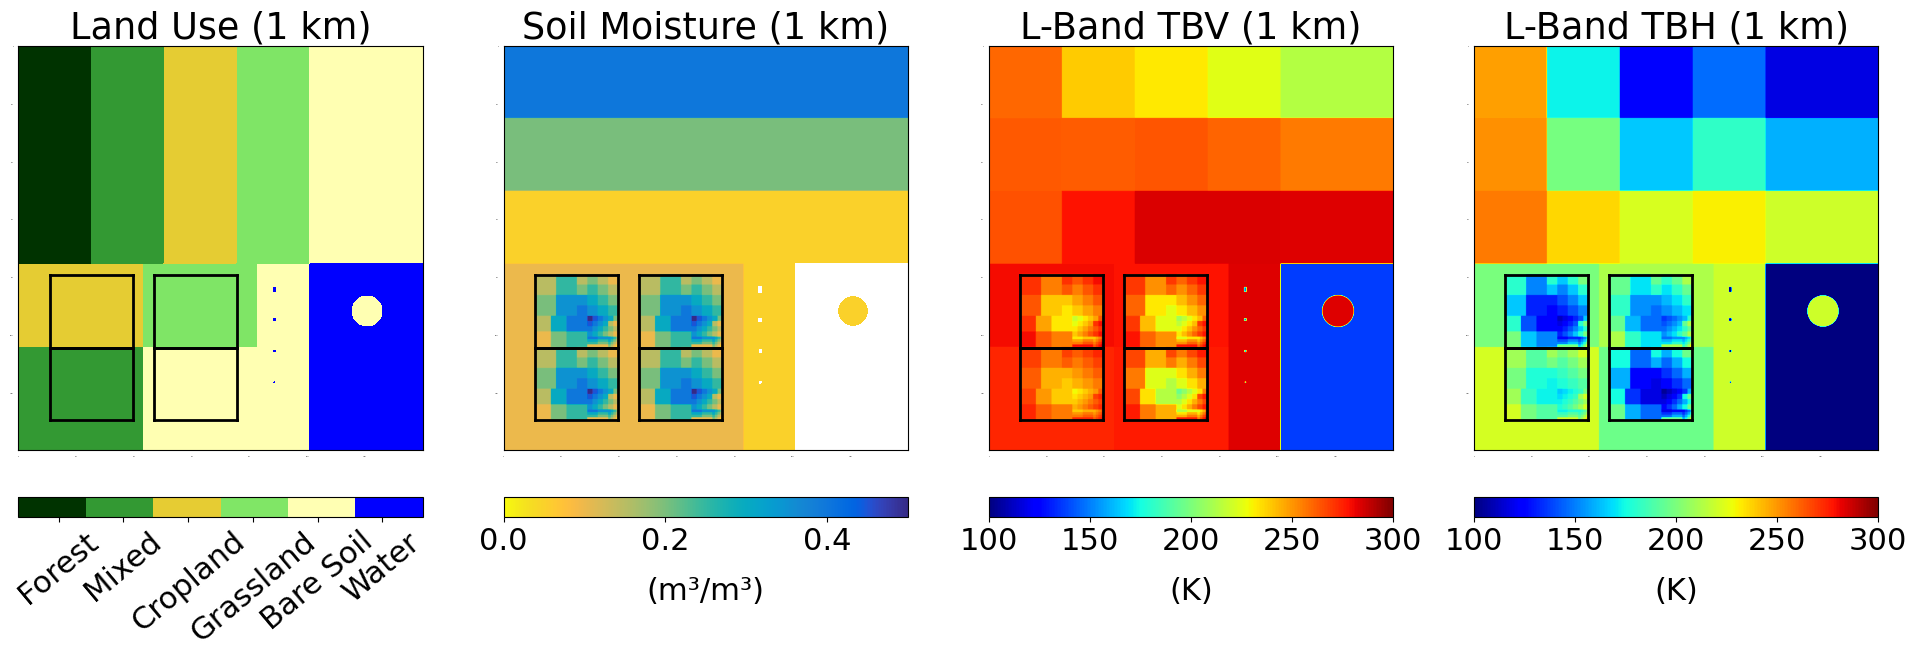

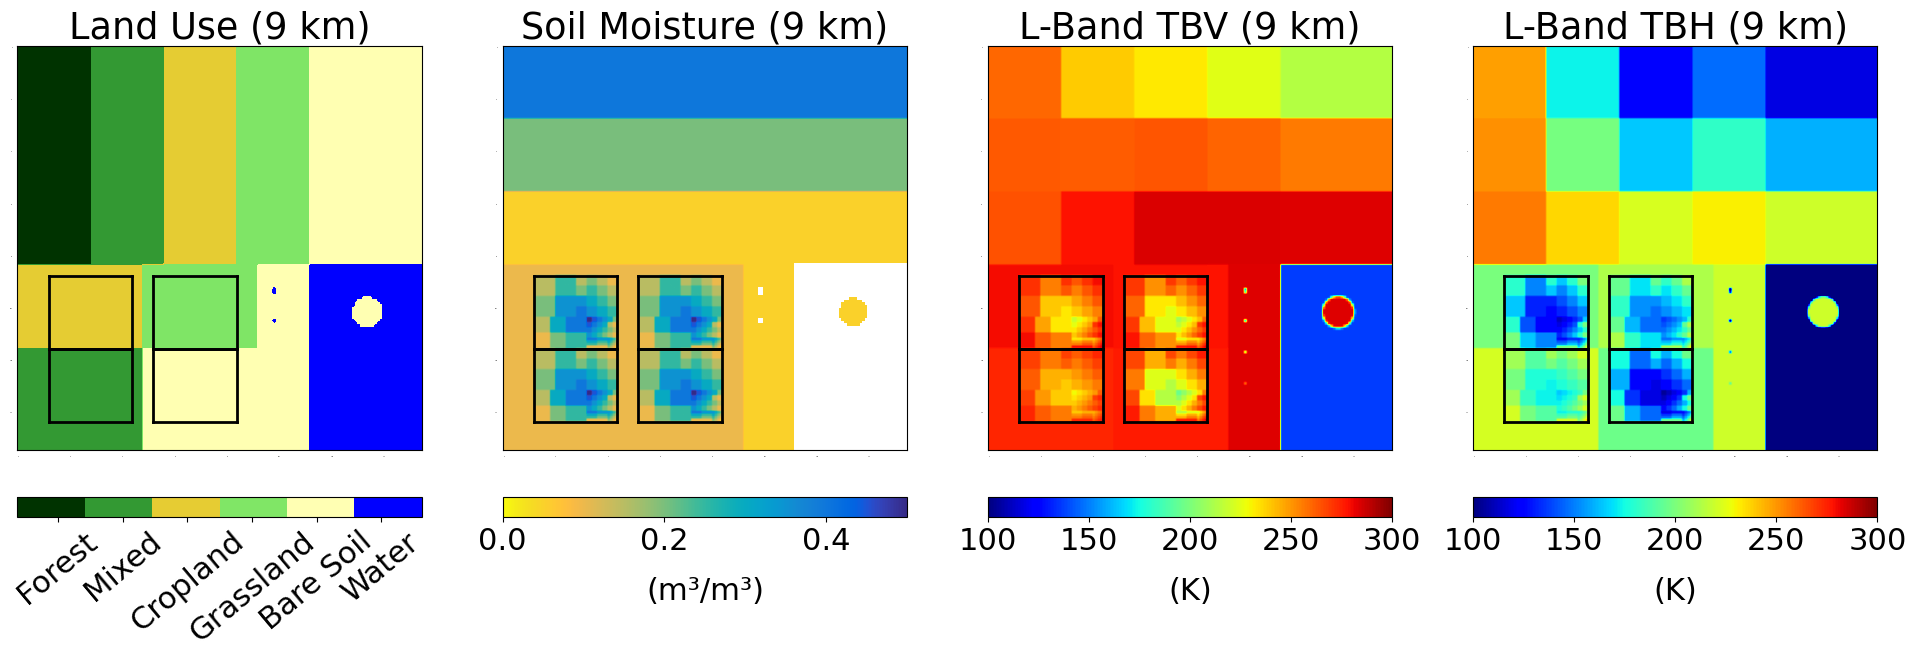

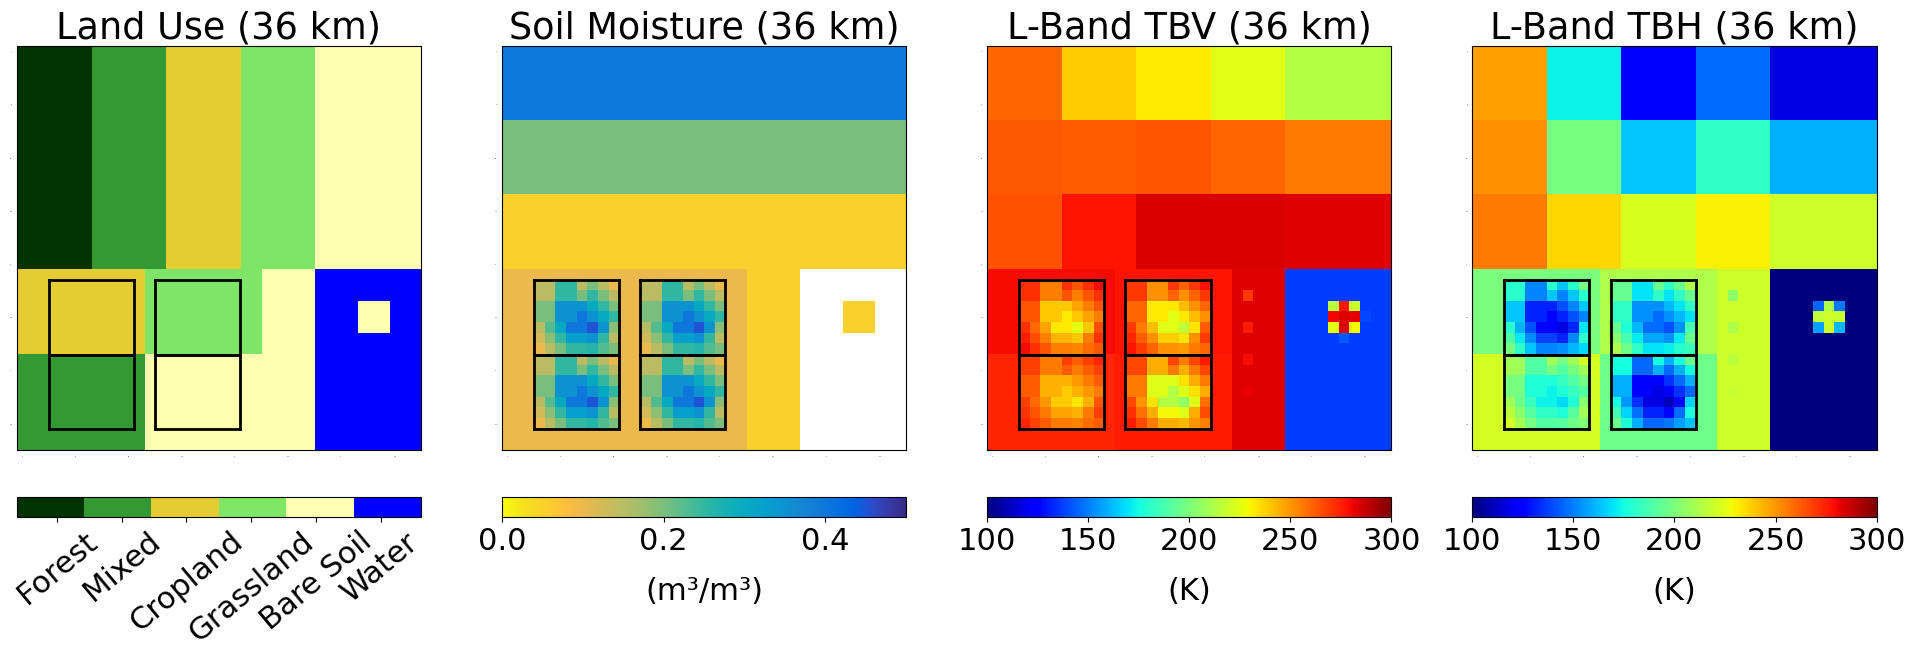

In [3]:
reload(sm_eval)

# Visualize soil moisture test card
cmap_landuse = colors.ListedColormap([[0, 0.2, 0], [0.2, 0.6, 0.2], [0.9, 0.8, 0.2], 
                                      [0.5, 0.9, 0.4], [1, 1, 0.7], [0, 0, 1]])

# Plot testcard at 1 km
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(24, 12))
grid = 1
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_tc(testcard['Land Use'], 'Land Use', grid, [0, 5], cmap_landuse)
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_tc(testcard['Soil Moisture'], 'Soil Moisture', grid, [0, 0.5])
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_tc(testcard['L_band_V'], 'L-Band TBV', grid, [100, 300], plt.cm.jet)
ax = fig.add_subplot(gs[0, 3])
sm_eval.plot_tc(testcard['L_band_H'], 'L-Band TBH', grid, [100, 300], plt.cm.jet)

# Plot testcard at 9 km
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(24, 12))
grid = 9
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_tc(tc_09['lu'], 'Land Use', grid, [0, 5], cmap_landuse)
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_tc(tc_09['Soil Moisture'], 'Soil Moisture', grid, [0, 0.5])
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_tc(tc_09['L_band_V'], 'L-Band TBV', grid, [100, 300], plt.cm.jet)
ax = fig.add_subplot(gs[0, 3])
sm_eval.plot_tc(tc_09['L_band_H'], 'L-Band TBH', grid, [100, 300], plt.cm.jet)

# Plot testcard at 36 km
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(24, 12))
grid = 36
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_tc(tc_36['lu'], 'Land Use', grid,  [0, 5], cmap_landuse)
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_tc(tc_36['Soil Moisture'], 'Soil Moisture', grid, [0, 0.5])
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_tc(tc_36['L_band_V'], 'L-Band TBV', grid, [100, 300], plt.cm.jet)
ax = fig.add_subplot(gs[0, 3])
sm_eval.plot_tc(tc_36['L_band_H'], 'L-Band TBH', grid, [100, 300], plt.cm.jet)

## Step 1: Load and resample L1 data



### Step 1a: Load L1B files

Four simulated CIMR overpasses are available for the soil moisture test card. The L1B files are based on two independent orbit simulators, implemented by DEIMOS and SCEPS, respectively. Each orbit simulator covers one ascending and descending orbit, respectively. 

In [4]:
# Select bands
bands = ["L", "C"]

# Define L1B Files
file_deimos_asc = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20231106T111913_LD_20280107T174033_20280107T174933_TN_asc.nc'
file_deimos_des = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20231115T111345_LD_20280122T061000_20280122T062400_TN_desc.nc'
file_sceps_asc = 'SCEPS_l1b_devalgo_test_scene_3_unfiltered_asc_tot_minimal_nom_nedt_apc_tot_v2p1.nc'
file_sceps_des = 'SCEPS_l1b_devalgo_test_scene_3_unfiltered_desc_tot_minimal_nom_nedt_apc_tot_v2p1.nc'

# read L1B Files
l1b_deimos_asc = CIMR_L1B(os.path.join(datapath, 'L1B', file_deimos_asc), selected_bands=bands, keep_calibration_view=True,)
l1b_deimos_des = CIMR_L1B(os.path.join(datapath, 'L1B', file_deimos_des), selected_bands=bands, keep_calibration_view=True,)
l1b_sceps_asc = CIMR_L1B(os.path.join(datapath, 'L1B', file_sceps_asc), selected_bands=bands, keep_calibration_view=True,)
l1b_sceps_des = CIMR_L1B(os.path.join(datapath, 'L1B', file_sceps_des), selected_bands=bands, keep_calibration_view=True,)


### Step 1b: Regrid L1B to L1X

The soil moisture algorithm requires gridded TBs as an input. We call the gridded TBs "L1X" 
- L-band TBs are gridded to the 36 km global EASE2 grid. The dataset will serve as an input for soil moisture retrievals at the 36 km scale.
- C-band TBs are gridded to the 9 km global EASE2 grid. This dataset is used in a later step to sharpen 36 km gridded L-band TBs to derive an enhanced resolution L-band TB dataset, gridded at 9 km. This dataset will serve as an input for soil moisture retrievals at the 9 km grid.

For this prototype implementation, a Gaussian regridding is applied. The corresponding grid definitions are loaded from an external file.

In [5]:
reload(resample)

# Grid definitions
grid_def_file = os.path.join(basedir, algodir, 'grids_py.def')
ease_36 = parse_area_file(grid_def_file, 'global-ease2-360')[0]
ease_09 = parse_area_file(grid_def_file, 'global-ease2-090')[0]

# Settings
what = ['brightness_temperature_v', 'brightness_temperature_h']
bands = ['L', 'C']
area_defs = [ease_36, ease_09]
method = 'gauss'

# Resample L1B files
l1x_deimos_asc = resample.resample(l1b_deimos_asc.data, bands, area_defs, what, method)
l1x_deimos_des = resample.resample(l1b_deimos_des.data, bands, area_defs, what, method)
l1x_sceps_asc = resample.resample(l1b_sceps_asc.data, bands, area_defs, what, method)
l1x_sceps_des = resample.resample(l1b_sceps_des.data, bands, area_defs, what, method)


c:\Users\mlink\Work\Projects\DEVALGO\Github\SoilMoisture_ATBD_v2\.conda\Lib\site-packages\pyresample\kd_tree.py:261: UserWarning: Possible more than 8 neighbours within 40000 m for some data points
  get_neighbour_info(source_geo_def,
c:\Users\mlink\Work\Projects\DEVALGO\Github\SoilMoisture_ATBD_v2\.conda\Lib\site-packages\pyresample\kd_tree.py:261: UserWarning: Possible more than 8 neighbours within 15000 m for some data points
  get_neighbour_info(source_geo_def,


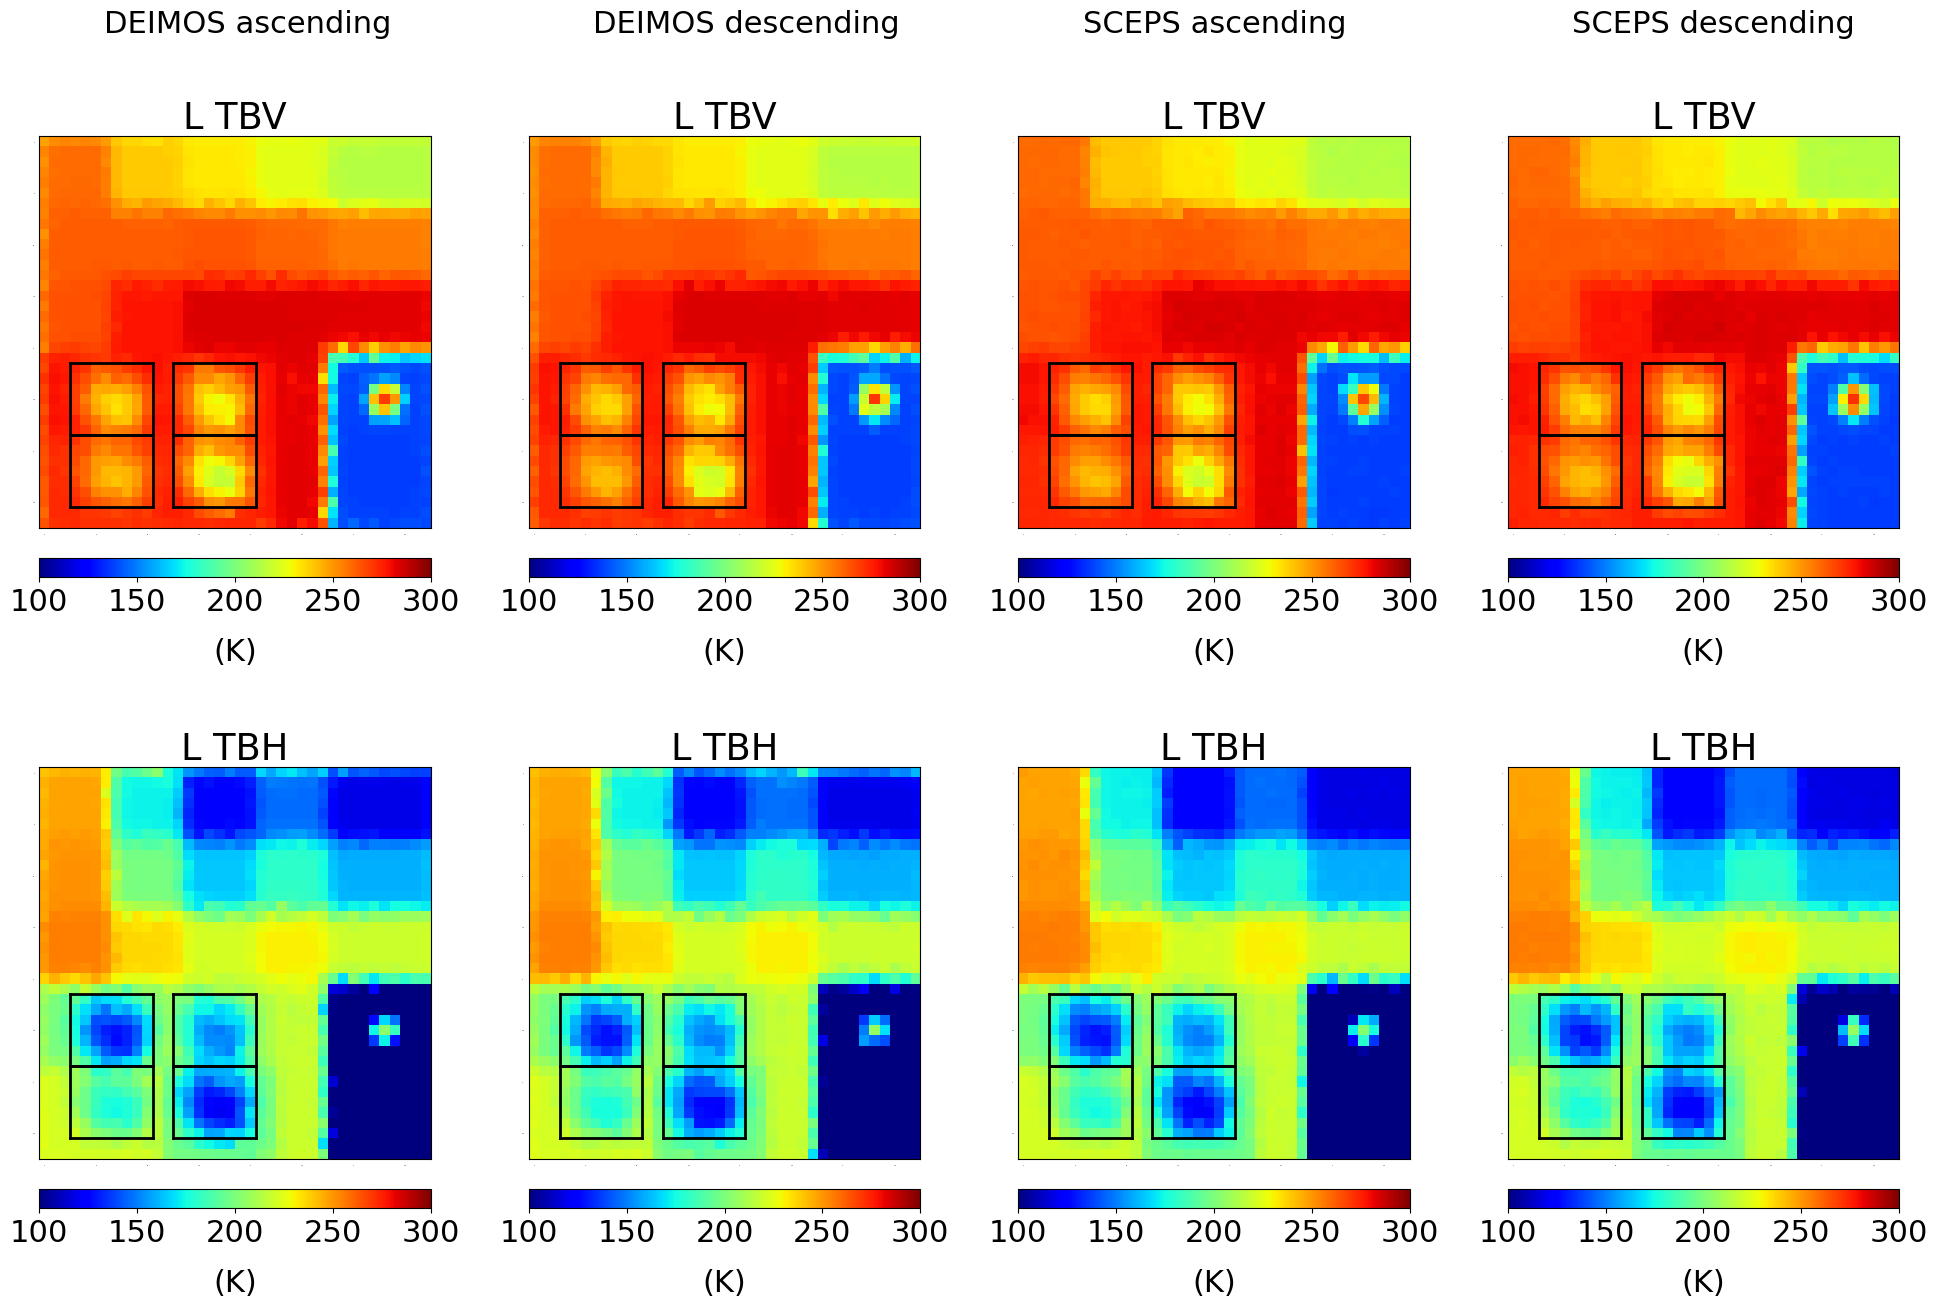

In [6]:
reload(sm_eval)

# Plot l1X data
files = [l1x_deimos_asc, l1x_deimos_des, l1x_sceps_asc, l1x_sceps_des]
filenames = ['DEIMOS ascending', 'DEIMOS descending', 'SCEPS ascending', 'SCEPS descending']
bands = ['L']
what = ['brightness_temperature_v', 'brightness_temperature_h']
whatname  = ['TBV', 'TBH']
sm_eval.plot_l1x(files, filenames, bands, what, whatname, [100, 300], plt.cm.jet)


### Step 1c: Sharpen L1X -> L1X_E

In a separate step, we sharpen the L-band TBs by means of higher resolution C-band TBs. The result is an enhanced resolution L-band dataset gridded at 9 km, which we call "L1X_E". To this end, the following procedure is adopted, which takes lower-resolution L-band TBs (36 km grid) and higher-resolution C-band TBs (9 km grid) as inputs.

$$ 
TB_L(9) = \frac{TB_L(36)}{TB_C(36)} TB_C(9)
$$

Here, $TB_C(36 km)$ is the aggregation of $TB_C(9 km)$ to the 36 km grid. This procedure is similar to the smoothing filter-based intensity modulation technique (SFIM) [Santi, 2010], while the mean L-band TB of each 36 km pixel is preserved. The final sharpening algorithm for CIMR will be determined based on further tests. 

In [7]:
# Settings
band_lr = 'L'
band_hr = 'C'                                 
what = ['brightness_temperature_v', 'brightness_temperature_h']
aoi_36 = np.array([82, 120, 463, 501])

# apply SFIM downscaling
l1x = {}
l1x_e_deimos_asc = resample.sharpen(l1x_deimos_asc, band_lr, band_hr, what, aoi_36, verbose=False)
l1x_e_deimos_des = resample.sharpen(l1x_deimos_des, band_lr, band_hr, what, aoi_36, verbose=False)
l1x_e_sceps_asc = resample.sharpen(l1x_sceps_asc, band_lr, band_hr, what, aoi_36, verbose=False)
l1x_e_sceps_des = resample.sharpen(l1x_sceps_des, band_lr, band_hr, what, aoi_36, verbose=False)


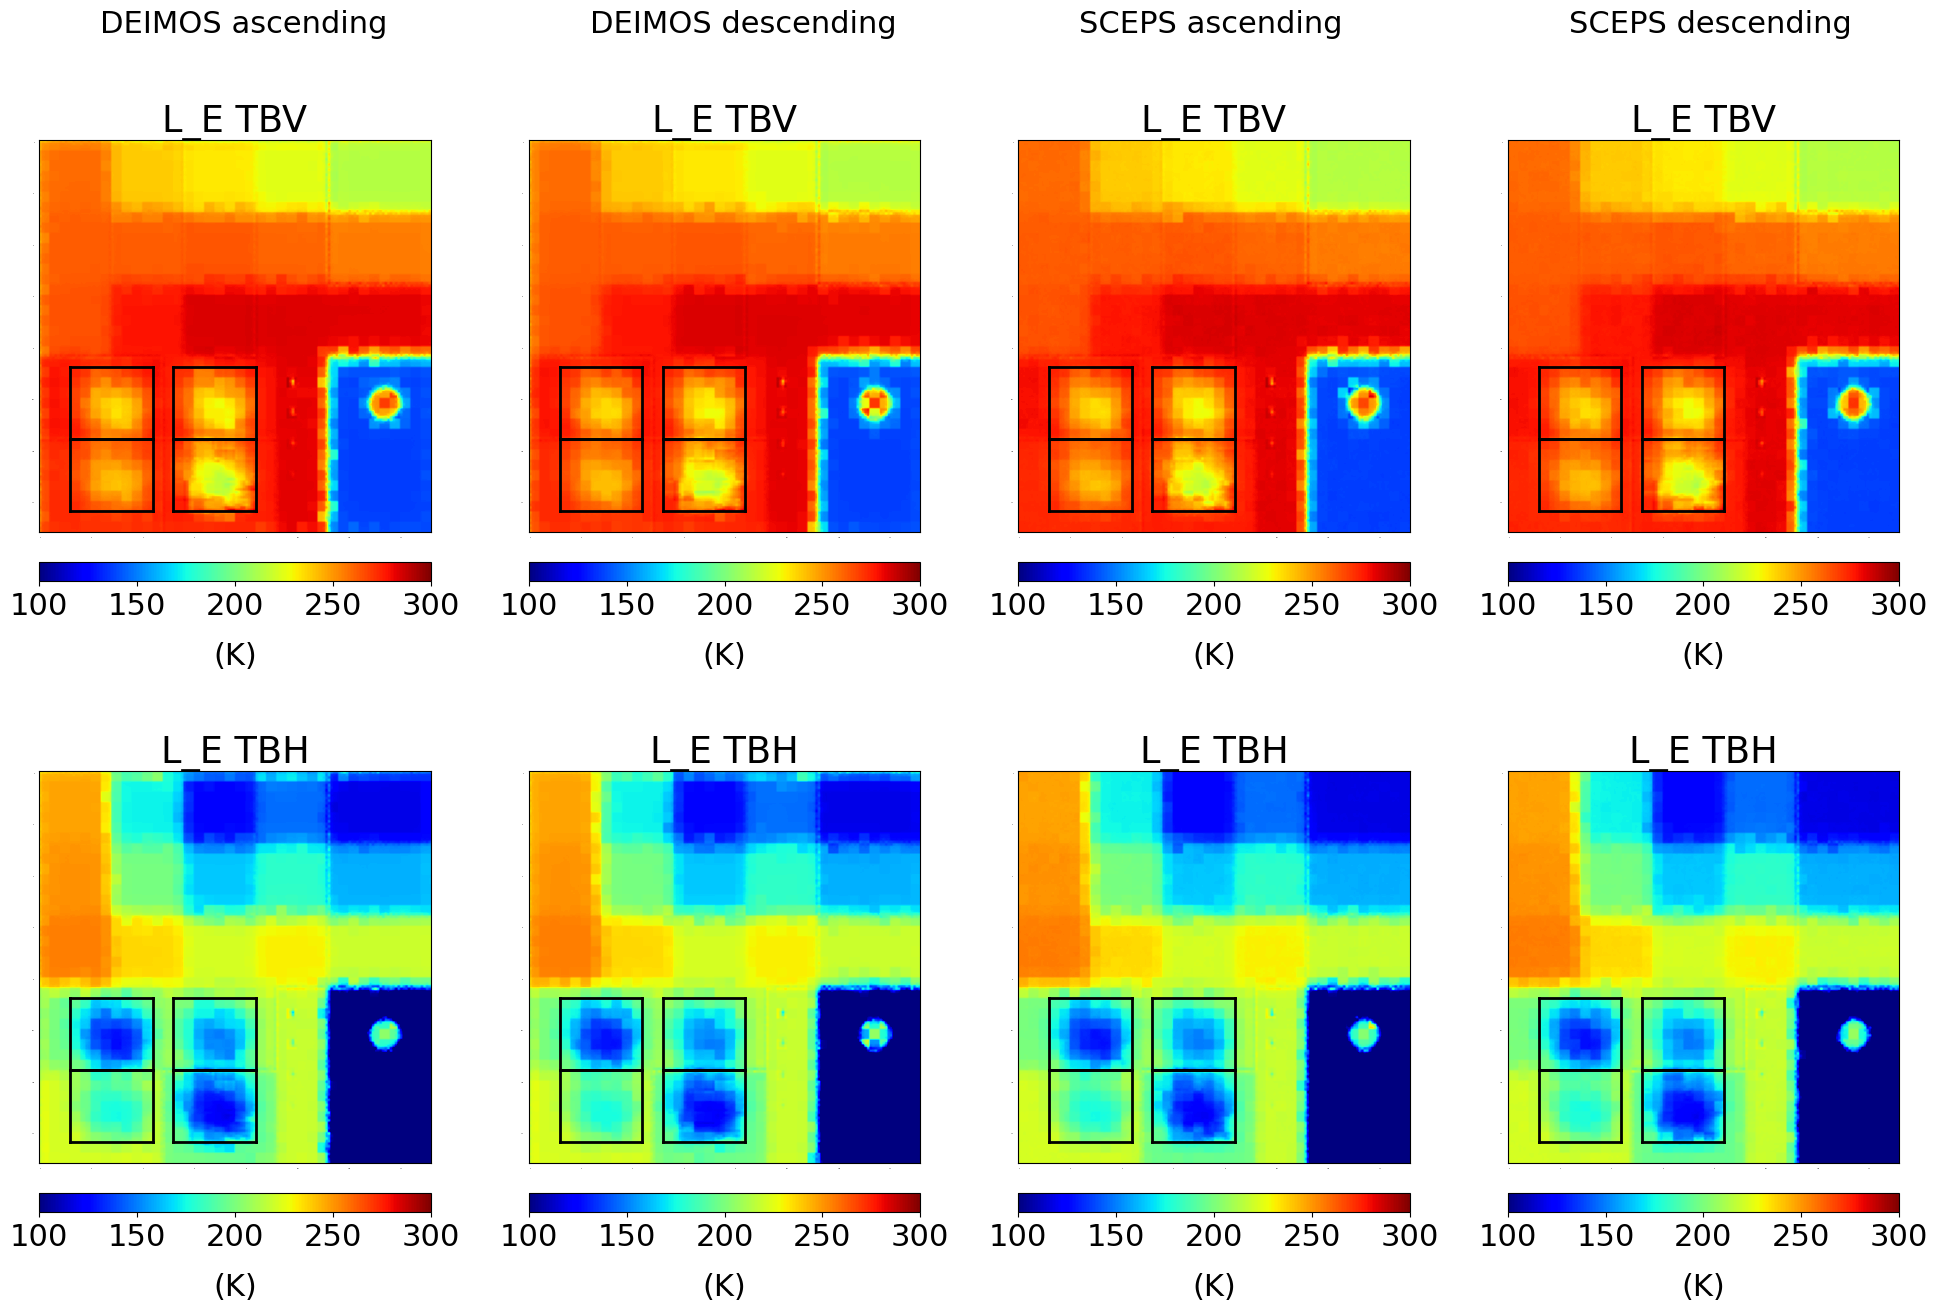

In [8]:
reload(sm_eval)

# Plot l1X_E data
files = [l1x_e_deimos_asc, l1x_e_deimos_des, l1x_e_sceps_asc, l1x_e_sceps_des]
filenames = ['DEIMOS ascending', 'DEIMOS descending', 'SCEPS ascending', 'SCEPS descending']
bands = ['L_E']
what = ['brightness_temperature_v', 'brightness_temperature_h']
whatname = ['TBV', 'TBH']
sm_eval.plot_l1x(files, filenames, bands, what, whatname, [100, 300], plt.cm.jet)


## Step 2: Soil moisture retrieval


### Step 2.1: Offline preparation of auxiliary and flag data

- We define a global set of constant parameters (frequency, incidence angle, ...)
- We prepare auxiliary and flag arrays. All preparations are done offline. In this prototype version, time-dynamic auxiliary data (e.g., LST) is not updated, since only one time step is available. In later versions, time-dynamic data arrays will either be updated before passing or passed separately.
- Certain auxiliary data (h,  omega, tau_ini) are land use dependent. Static maps of these parameters are constructed based on a look up table. The parameters are not calibrated and follow the initial proposal in [Baseline Algorithm Definition](https://cimr-algos.github.io/SoilMoisture_ATBD/baseline_algorithm_definition.html#baseline-algorithm-definition). The only exception is the omega parameter for forest retrievals, which is set to 0.11 for this prototype (instead of a lower value of 0.06, which led to a wet bias in the retrievals). Note that forest retrievals are not part of the algorithm evaluation due to high vegetation density.
- A static map of vegetation water content (VWC) is used to flag for dense vegetation cover. The VWC values in the look up table result from the configurations used in the discrete numerical forward model. 
- Certain flags are expected to be implemented in CIMR but are not relevant for this test card (urban fraction, precipitation rate, frozen land cover fraction, snow fraction, and mountainous terrain). These flags are set to zero in this prototype. All flags are preliminary and may change in the operational implementation of CIMR.

In [23]:
# define algorithm version
algo_version = '0.1.1'

# global parameters
params = {
    'theta': 52.5,
    'f': 1.4,
    'Q': 0,
    'n': 2,
    'sm_ini': 0.1,
    'TB_std': 1.0
}

# bounds ([min_vod, min_sm], [max_vod, max_sm])
bounds = ([0, 0], [2, 0.6])

# land use dependent parameters and flags
# [forest, mixed, crop, grass, bare, water]
h = [0.4, 0.5, 0.4, 0.5, 0.1, np.nan]
omega = [0.11, 0.12, 0.12, 0.1, 0.12, np.nan]
tau_ini = [0.5, 0.4, 0.4, 0.2, 0, np.nan]
vwc = [11.75, 4.63, 1.95, 0.21, 0, np.nan]

# auxiliary and flag arrays at 36 km
shape = tc_36['lu'].shape
# auxiliary
aux_36 = {}
aux_36['h'] = resample.compute_aux_lookup(h, tc_36['lu'])
aux_36['omega'] = resample.compute_aux_lookup(omega, tc_36['lu'])
aux_36['tau_ini'] = resample.compute_aux_lookup(tau_ini, tc_36['lu'])
aux_36['LST'] = np.ones(shape) * 288.
aux_36['cf'] = np.ones(shape) * 0.15
# flags
flag_36 = {}
flag_36['Water Fraction'] = tc_36['wf']
flag_36['Coast Distance'] = tc_36['cd']
flag_36['VWC'] = resample.compute_aux_lookup(vwc, tc_36['lu'])
flag_36['Urban Fraction'] = np.zeros(shape)                                   
flag_36['Precip Rate'] = np.zeros(shape)                                  
flag_36['Frozen Fraction'] = np.zeros(shape)
flag_36['Snow Fraction'] = np.zeros(shape)
flag_36['DEM STD'] = np.zeros(shape)

# auxiliary and flag arrays at 9 km
shape = tc_09['lu'].shape
# auxiliary
aux_09 = {}
aux_09['h'] = resample.compute_aux_lookup(h, tc_09['lu'])
aux_09['omega'] = resample.compute_aux_lookup(omega, tc_09['lu'])
aux_09['tau_ini'] = resample.compute_aux_lookup(tau_ini, tc_09['lu'])
aux_09['LST'] = np.ones(shape) * 288.
aux_09['cf'] = np.ones(shape) * 0.15
# flags
flag_09 = {}
flag_09['Water Fraction'] = tc_09['wf']
flag_09['Coast Distance'] = tc_09['cd']
flag_09['VWC'] = resample.compute_aux_lookup(vwc, tc_09['lu'])
flag_09['Urban Fraction'] = np.zeros(shape)
flag_09['Precip Rate'] = np.zeros(shape)
flag_09['Frozen Fraction'] = np.zeros(shape)
flag_09['Snow Fraction'] = np.zeros(shape)
flag_09['DEM STD'] = np.zeros(shape)


### Step 2.2: Soil moisture retrieval algorithm

- We apply the prototype soil moisture retrieval algorithm to 36 km gridded TBs (L-band only) and 9 km gridded TBs (L-band sharpened with C-band).
- All operations, including the initialization and optimization of the algorithm, are carried out within the function sm_ret in the [sm_algorithm module](https://github.com/CIMR-Algos/SoilMoisture_ATBD_v2/blob/main/algorithm/sm_algo/sm_algorithm.py).
- The optimization aims to find a least-squares fit between the gridded L-band TBs and corresponding forward model simulations. The optimization is regularized by an initial guess of vegetation optical depth. For this prototype version, the initial guess is based on land cover. We have verified that the initial guess has a negligible impact on the retrieval results for the synthetic data assessed here. 
- The algorithm forward model is different from the numerical forward model used in the TB simulations.

In [24]:
reload(algo)

# soil moisture retrieval at 36 km grid
l2_36_deimos_asc = algo.sm_ret(l1x_deimos_asc, params, aux_36, flag_36, bounds)
l2_36_deimos_des = algo.sm_ret(l1x_deimos_des, params, aux_36, flag_36, bounds)
l2_36_sceps_asc = algo.sm_ret(l1x_sceps_asc, params, aux_36, flag_36, bounds)
l2_36_sceps_des = algo.sm_ret(l1x_sceps_des, params, aux_36, flag_36, bounds)

Soil Moisture Retrieval: Global Equal Area grid (36.0 km)
Soil Moisture Retrieval: Global Equal Area grid (36.0 km)
Soil Moisture Retrieval: Global Equal Area grid (36.0 km)
Soil Moisture Retrieval: Global Equal Area grid (36.0 km)


In [26]:
reload(algo)

# soil moisture retrieval at 9 km grid
l2_09_deimos_asc = algo.sm_ret(l1x_e_deimos_asc, params, aux_09, flag_09, bounds)
l2_09_deimos_des = algo.sm_ret(l1x_e_deimos_des, params, aux_09, flag_09, bounds)
l2_09_sceps_asc = algo.sm_ret(l1x_e_sceps_asc, params, aux_09, flag_09, bounds)
l2_09_sceps_des = algo.sm_ret(l1x_e_sceps_des, params, aux_09, flag_09, bounds)

Soil Moisture Retrieval: Global Equal Area grid (9.0 km)
Soil Moisture Retrieval: Global Equal Area grid (9.0 km)
Soil Moisture Retrieval: Global Equal Area grid (9.0 km)
Soil Moisture Retrieval: Global Equal Area grid (9.0 km)


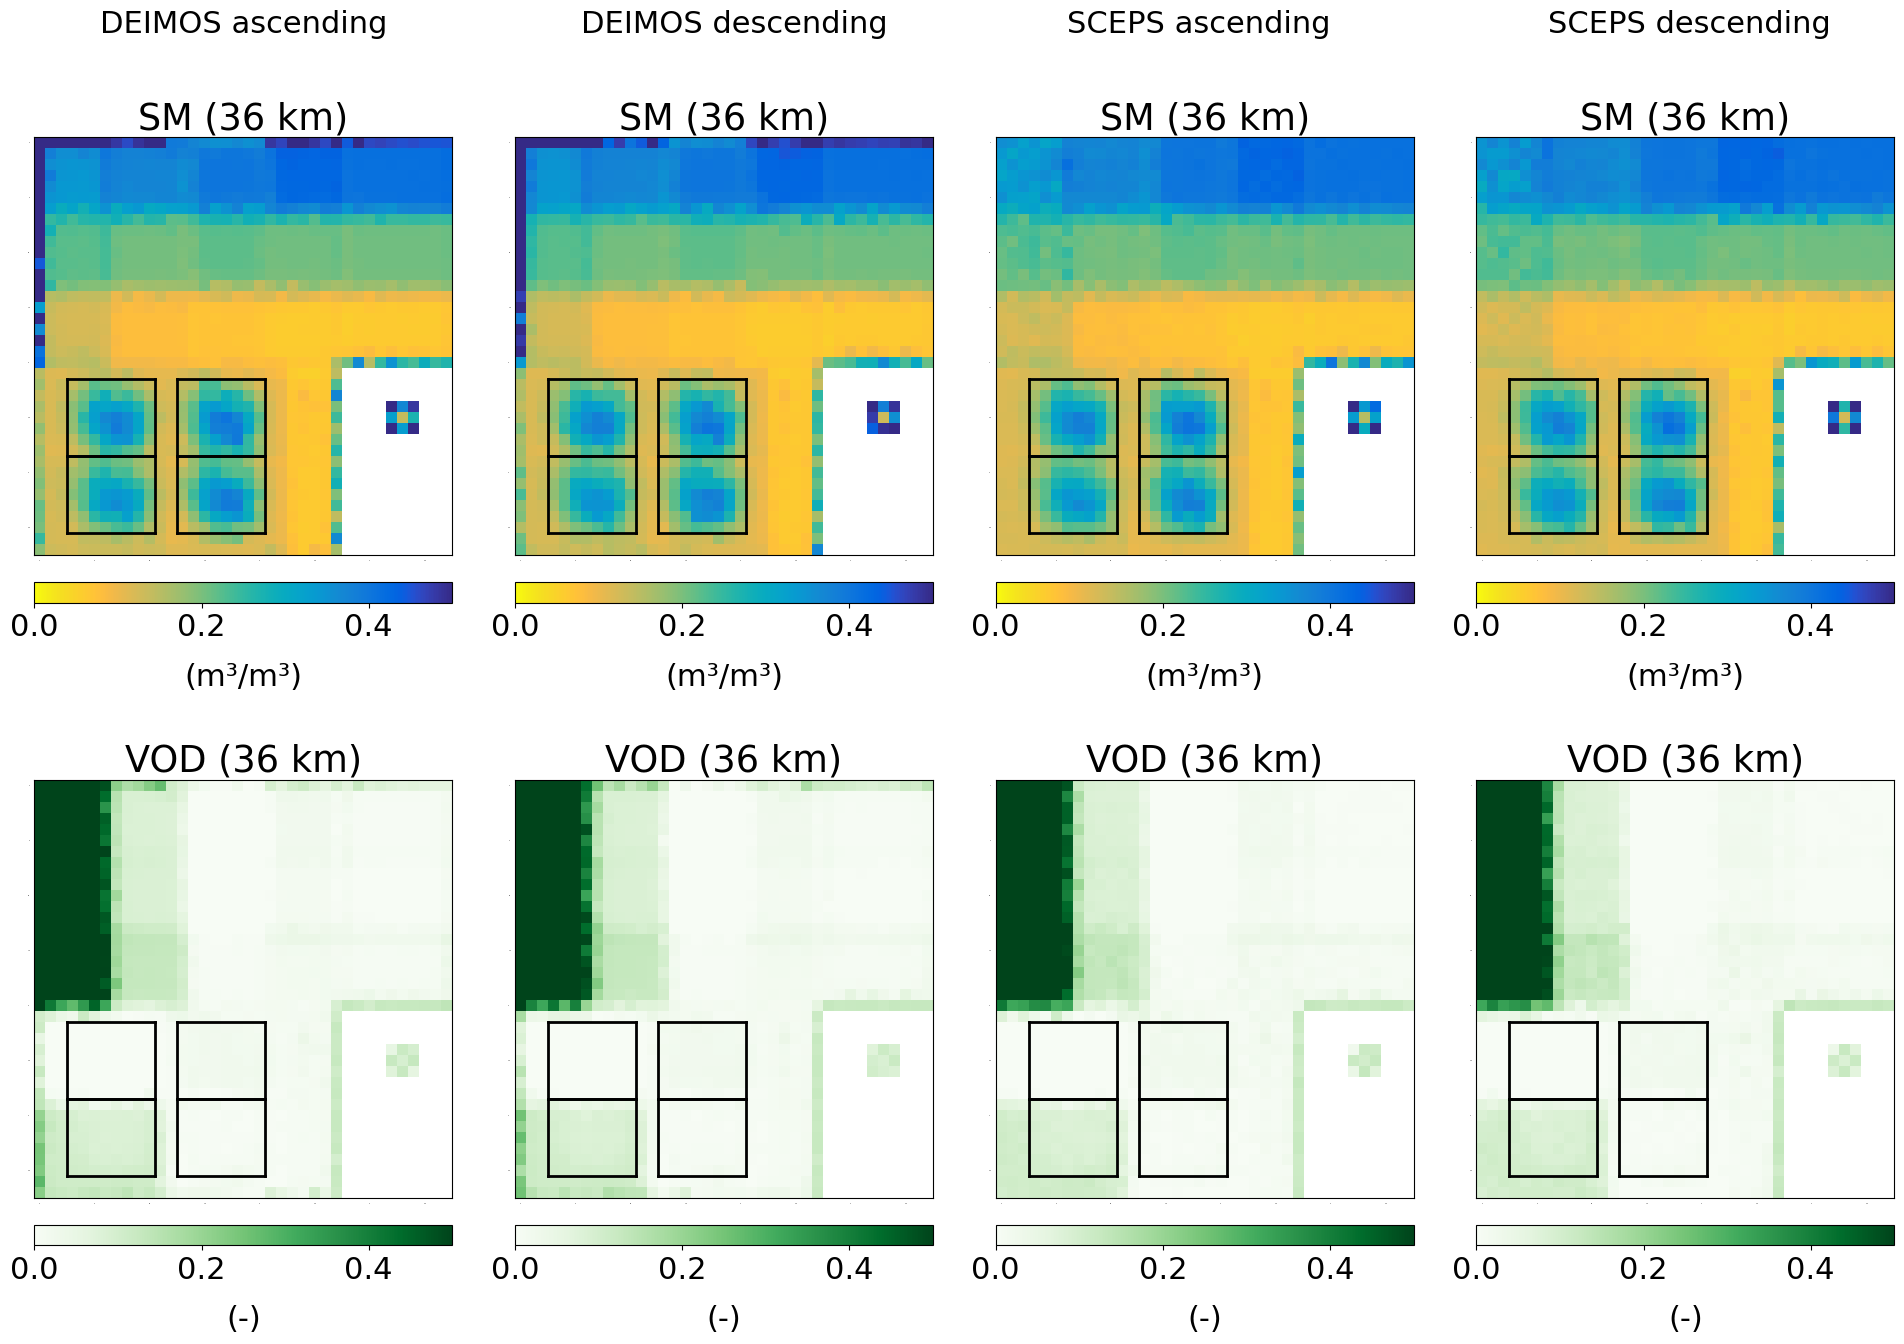

In [28]:
# Visualization of the results
reload(sm_eval)

# Settings and colormaps
filenames = ['DEIMOS ascending', 'DEIMOS descending', 'SCEPS ascending', 'SCEPS descending']

# 36 km
reference = tc_36['Soil Moisture']
deimos_asc = l2_36_deimos_asc
deimos_des = l2_36_deimos_des
sceps_asc = l2_36_sceps_asc
sceps_des = l2_36_sceps_des
plot_range = [0, 0.5]
grid = 36

# Plot
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(24, 32))
# SM
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_sm(deimos_asc['sm'], 'SM (36 km)', grid, plot_range)
plt.text(5.5, -10, filenames[0])
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_sm(deimos_des['sm'], 'SM (36 km)', grid, plot_range)
plt.text(5.5, -10, filenames[1])
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_sm(sceps_asc['sm'], 'SM (36 km)', grid, plot_range)
plt.text(6, -10, filenames[2])
ax = fig.add_subplot(gs[0, 3])
sm_eval.plot_sm(sceps_des['sm'], 'SM (36 km)', grid, plot_range)
plt.text(6, -10, filenames[3])
# VOD
ax = fig.add_subplot(gs[1, 0])
sm_eval.plot_sm(deimos_asc['vod'], 'VOD (36 km)', grid, plot_range, 'Greens')
ax = fig.add_subplot(gs[1, 1])
sm_eval.plot_sm(deimos_des['vod'], 'VOD (36 km)', grid, plot_range, 'Greens')
ax = fig.add_subplot(gs[1, 2])
sm_eval.plot_sm(sceps_asc['vod'], 'VOD (36 km)', grid, plot_range, 'Greens')
ax = fig.add_subplot(gs[1, 3])
sm_eval.plot_sm(sceps_des['vod'], 'VOD (36 km)', grid, plot_range, 'Greens')
# adjust
plt.subplots_adjust(wspace=0.15, hspace=0.2)


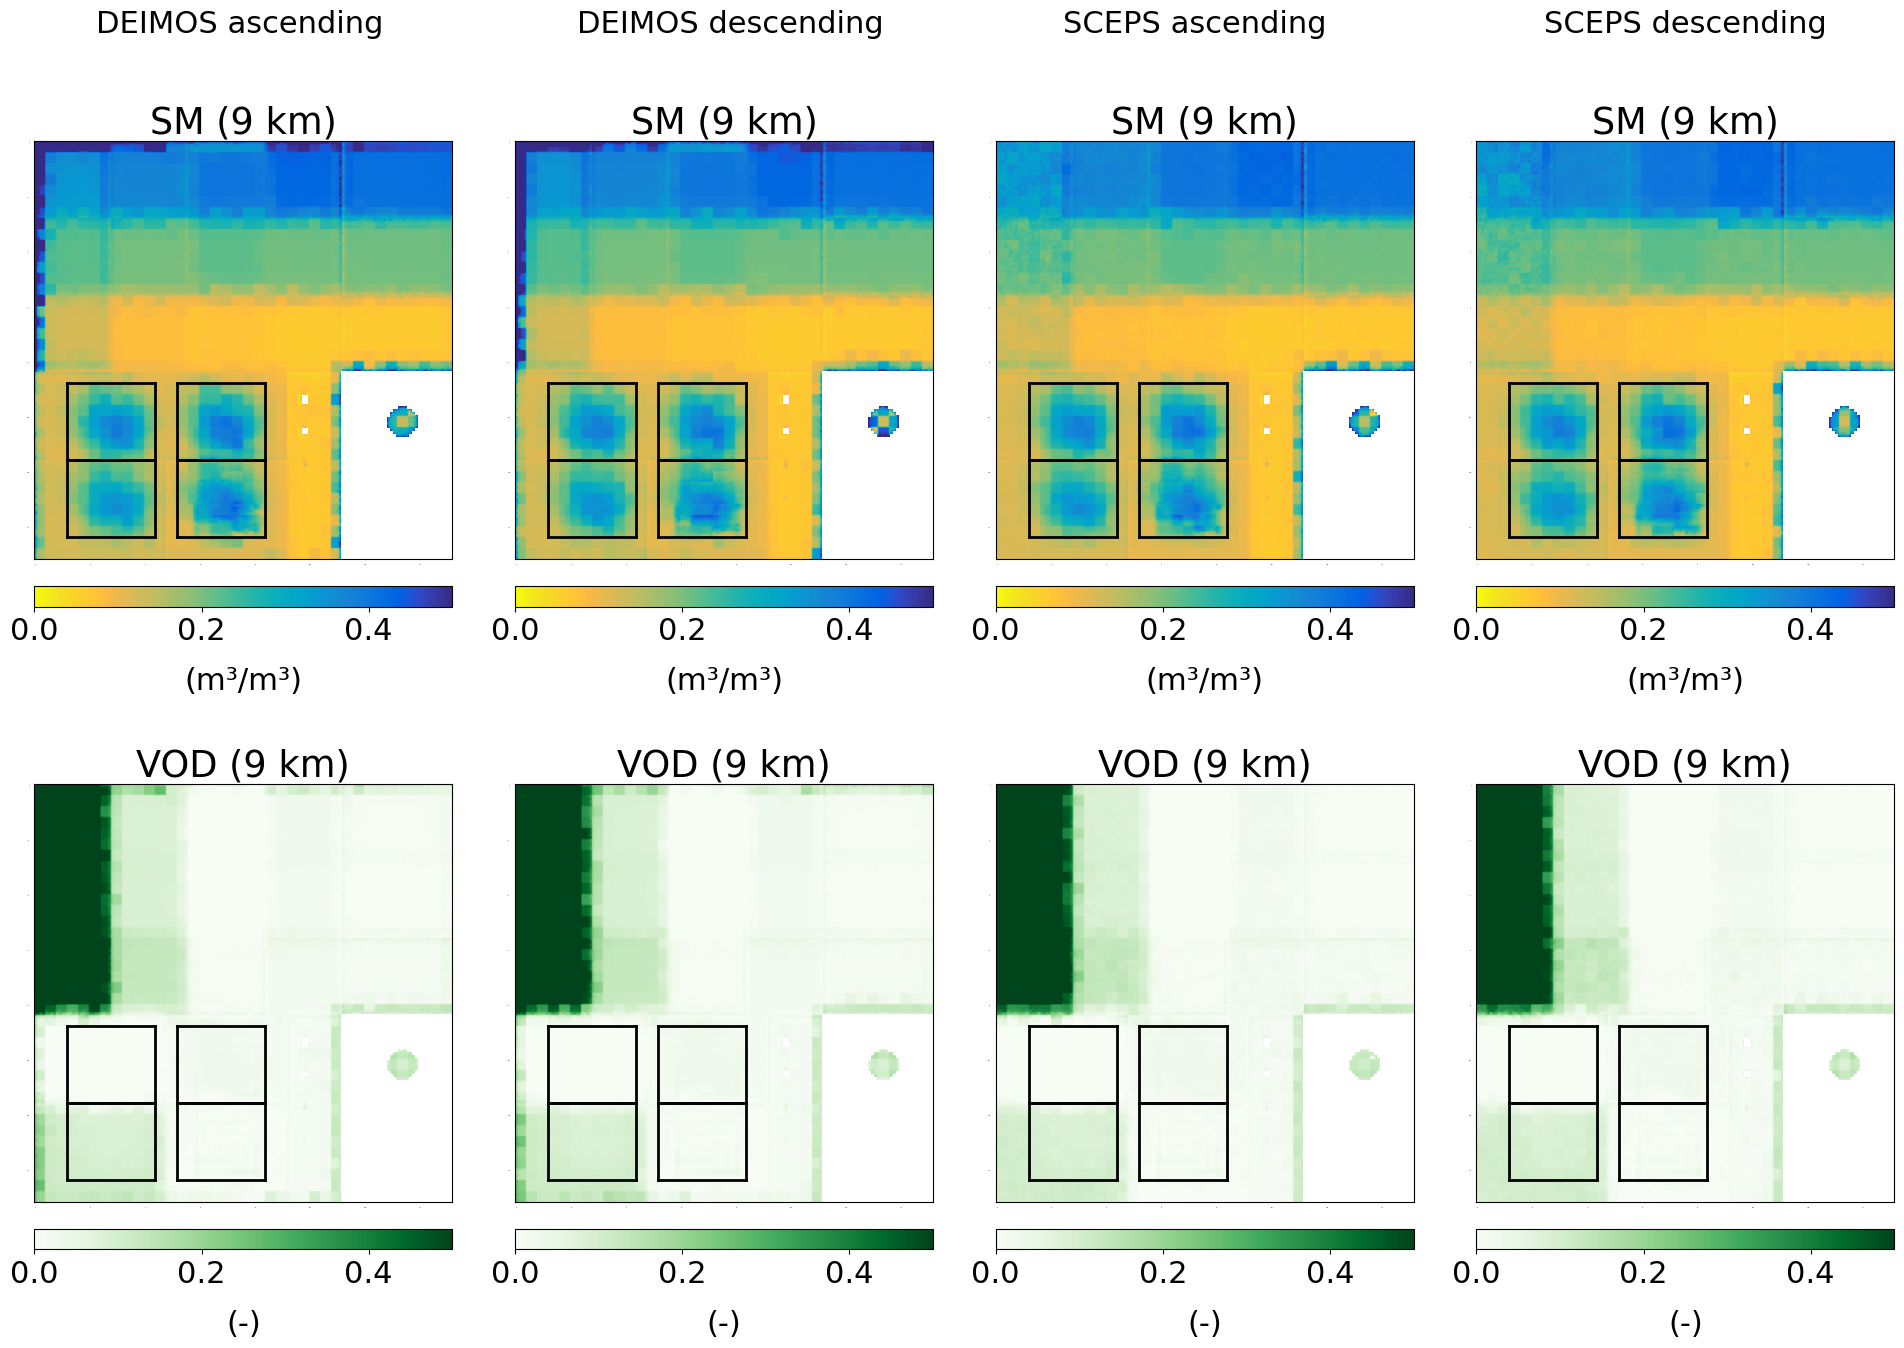

In [29]:
reload(sm_eval)

# 9 km
reference = tc_09['Soil Moisture'][:152, :152]
deimos_asc = l2_09_deimos_asc
deimos_des = l2_09_deimos_des
sceps_asc = l2_09_sceps_asc
sceps_des = l2_09_sceps_des
plot_range = [0, 0.5]
plt_range_flags = [0, 4]
grid = 9

# Plot
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(24, 32))
# SM
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_sm(deimos_asc['sm'], 'SM (9 km)', grid, plot_range)
plt.text(22, -40, filenames[0])
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_sm(deimos_des['sm'], 'SM (9 km)', grid, plot_range)
plt.text(22, -40, filenames[1])
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_sm(sceps_asc['sm'], 'SM (9 km)', grid, plot_range,)
plt.text(24, -40, filenames[2])
ax = fig.add_subplot(gs[0, 3])
sm_eval.plot_sm(sceps_des['sm'], 'SM (9 km)', grid, plot_range)
plt.text(24, -40, filenames[3])
# VOD
ax = fig.add_subplot(gs[1, 0])
sm_eval.plot_sm(deimos_asc['vod'], 'VOD (9 km)', grid, plot_range, 'Greens')
ax = fig.add_subplot(gs[1, 1])
sm_eval.plot_sm(deimos_des['vod'], 'VOD (9 km)', grid, plot_range, 'Greens')
ax = fig.add_subplot(gs[1, 2])
sm_eval.plot_sm(sceps_asc['vod'], 'VOD (9 km)', grid, plot_range, 'Greens')
ax = fig.add_subplot(gs[1, 3])
sm_eval.plot_sm(sceps_des['vod'], 'VOD (9 km)', grid, plot_range, 'Greens')
# adjust
plt.subplots_adjust(wspace=0.15, hspace=0.2)

## Step 3: Write Level-2 product file

We write a netCDF/CF file containing the retrieved soil moisture dataset and auxiliary data. For brevity, we demonstrate the process only for one file (corresponding to one distinct overpass). 

In [33]:
# settings
l2_path = os.path.join(datapath, 'L2')
l2_grid = ease_36
l2 = l2_36_deimos_asc
l1b = l1b_deimos_asc
l1x = l1x_deimos_asc
file = file_deimos_asc
name = 'deimos_asc'

In [35]:
# associate time to L2 products
min_l1b_dt = l1b.data['L']['time_earth'].data.min()
max_l1b_dt = l1b.data['L']['time_earth'].data.max()

# some simulated files have a wrong units of "days", then we get 'time_earth' as timedelta64.
#   fix for these
if l1b.data['C']['time_earth'].encoding['units'] == 'days':
    print("Correct L1B time (wrong unit in L1B file)")
    min_l1b_dt += np.datetime64('2000-01-01')
    max_l1b_dt += np.datetime64('2000-01-01')

# arbitrarily, associate middle time of l1b to l2
l2_dt = min_l1b_dt + (max_l1b_dt - min_l1b_dt) * 0.5

Correct L1B time (wrong unit in L1B file)


In [36]:
# get a template L2 format (netCDF/CF) from the Tools module
ds_l2 = get_CIMR_L2_template('grid', geo_def=l2_grid, add_time=[l2_dt, min_l1b_dt, max_l1b_dt])

# create a DataArray for SM from the template
data_array = l2['sm']
da_sm = xr.DataArray(np.reshape(data_array, (1,) + data_array.shape), 
                     coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                     attrs=ds_l2['template'].attrs, name='soil_moisture')
da_sm.attrs['long_name'] = 'Soil moisture retrievals for the {} grid'.format(l2_grid.proj_id)
da_sm.attrs['standard_name'] = 'soil_moisture_content'
da_sm.attrs['units'] = 'm3/m3'
da_sm.attrs['valid_range'] = 0, 1
da_sm.attrs['coverage_content_type'] = 'physicalMeasurement'
da_sm.attrs['auxiliary_variables'] = "vegetation_optical_depth, brightness_temperature_v, brightness_temperature_h, retrieval_scene_flag, retrieval_status_flag, rmse_tb"

# create a DataArray for VOD from the template
data_array = l2['vod']
da_vod = xr.DataArray(np.reshape(data_array, (1,) + data_array.shape), 
                     coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                     attrs=ds_l2['template'].attrs, name='vegetation_optical_depth')
da_vod.attrs['long_name'] = 'Vegetation optical depth (VOD) for the {} grid'.format(l2_grid.proj_id)
da_vod.attrs['units'] = 'unitless'
da_vod.attrs['valid_range'] = 0, np.inf
da_vod.attrs['coverage_content_type'] = 'auxiliaryInformation'

# create a DataArray for tbv from the template
data_array = l1x['L']['brightness_temperature_v']
da_tbv = xr.DataArray(np.reshape(data_array, (1,) + data_array.shape), 
                     coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                     attrs=ds_l2['template'].attrs, name='brightness_temperature_v')
da_tbv.attrs['long_name'] = 'L-band brightness temperature in V-polarization for the {} grid'.format(l2_grid.proj_id)
da_tbv.attrs['units'] = 'K'
da_tbv.attrs['valid_range'] = 0, np.inf
da_tbv.attrs['coverage_content_type'] = 'auxiliaryInformation'

# create a DataArray for tbv from the template
data_array = l1x['L']['brightness_temperature_h']
da_tbh = xr.DataArray(np.reshape(data_array, (1,) + data_array.shape), 
                     coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                     attrs=ds_l2['template'].attrs, name='brightness_temperature_h')
da_tbh.attrs['long_name'] = 'L-band brightness temperature in H-polarization for the {} grid'.format(l2_grid.proj_id)
da_tbh.attrs['units'] = 'K'
da_tbh.attrs['valid_range'] = 0, np.inf
da_tbh.attrs['coverage_content_type'] = 'auxiliaryInformation'

# create a DataArray for retrieval_scene_flag from the template
data_array = l2['flag_scene']
da_scene_flg = xr.DataArray(np.reshape(data_array, (1,) + data_array.shape), 
                           coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                           attrs=ds_l2['template'].attrs, name='retrieval_scene_flag')
da_scene_flg.attrs['long_name'] = 'Retrieval scene flag'
da_scene_flg.attrs['coverage_content_type'] = 'auxiliaryInformation'
da_scene_flg.attrs['valid_range'] = 0, 256
da_scene_flg.attrs['flag_masks'] = '1b, 2b, 4b, 8b, 16b, 32b, 64b, 128b' 
da_scene_flg.attrs['flag_meanings'] = 'water_fraction ' \
                                      'coastline_distance ' \
                                      'vegetation_cover ' \
                                      'urban_fraction ' \
                                      'precip_rate ' \
                                      'snow_fraction ' \
                                      'frozen_fraction ' \
                                      'mountain_terrain' 
    
# create a DataArray for retrieval_status_flag from the template
data_array = l2['flag_status']
da_status_flg = xr.DataArray(np.reshape(data_array, (1,) + data_array.shape), 
                           coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                           attrs=ds_l2['template'].attrs, name='retrieval_status_flag')
da_status_flg.attrs['long_name'] = 'Retrieval status flag'
da_status_flg.attrs['coverage_content_type'] = 'auxiliaryInformation'
da_status_flg.attrs['valid_range'] = 0, 2
da_status_flg.attrs['flag_values'] = 0, 1, 2
da_status_flg.attrs['flag_meanings'] = 'retrieval_attempted ' \
                                       'retrieval_not_attempted ' \
                                       'retrieval_not_succesful'

# create a DataArray for rmse_tb from the template
data_array = l2['rmse_tb']
da_rmse_tb = xr.DataArray(np.reshape(data_array, (1,) + data_array.shape), 
                          coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                          attrs=ds_l2['template'].attrs, name='rmse_tb')
da_rmse_tb.attrs['long_name'] = 'RMSE of simulated and observed brightness temperatures'
da_rmse_tb.attrs['units'] = 'K'
da_rmse_tb.attrs['valid_range'] = 0, np.inf
da_rmse_tb.attrs['coverage_content_type'] = 'auxiliaryInformation'

# add the data arrays to the ds_l2 object
ds_l2 = ds_l2.merge(da_sm)
ds_l2 = ds_l2.merge(da_vod)
ds_l2 = ds_l2.merge(da_scene_flg)
ds_l2 = ds_l2.merge(da_status_flg)
ds_l2 = ds_l2.merge(da_tbv)
ds_l2 = ds_l2.merge(da_tbh)
ds_l2 = ds_l2.merge(da_rmse_tb)

# customize the global attributes
ds_l2.attrs['title'] = 'CIMR L2 Soil Moisture'
ds_l2.attrs['summary'] = 'Soil Moisture computed with the prototype algorithm developed in the ESA CIMR DEVALGO study. The product file contains the soil moisture, the vegetation optical depth, and processing flags.'
ds_l2.attrs['l1b_file'] = os.path.basename(file)
ds_l2.attrs['algorithm_version'] = algo_version

ds_l2.attrs['creator_name'] = 'Moritz Link, Roberto Fernández-Morán, María Piles'
ds_l2.attrs['creator_email'] = 'moritz.link@uv.es'
ds_l2.attrs['institution'] = 'University of Valencia'

# remove the 'template' variable (we don't need it anymore)
ds_l2 = ds_l2.drop_vars('template')

# write to file
l2_n = 'cimr_devalgo_l2_sm_{}_{}.nc'.format(l2_grid.proj_id, name)
l2_n = os.path.join(l2_path, l2_n)
ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC')
print(ds_l2)



<xarray.Dataset> Size: 23MB
Dimensions:                   (time: 1, x: 964, y: 406, two: 2)
Coordinates:
  * time                      (time) datetime64[ns] 8B 2028-01-07T17:45:06.06...
  * x                         (x) float64 8kB -1.735e+07 ... 1.735e+07
  * y                         (y) float64 3kB 7.297e+06 7.26e+06 ... -7.297e+06
    lon                       (y, x) float64 3MB -179.8 -179.4 ... 179.4 179.8
    lat                       (y, x) float64 3MB 83.63 83.63 ... -83.63 -83.63
Dimensions without coordinates: two
Data variables:
    crs                       (time) int32 4B 0
    time_bnds                 (time, two) datetime64[ns] 16B 2028-01-07T17:40...
    soil_moisture             (time, y, x) float64 3MB nan nan nan ... nan nan
    vegetation_optical_depth  (time, y, x) float64 3MB nan nan nan ... nan nan
    retrieval_scene_flag      (time, y, x) int16 783kB -999 -999 ... -999 -999
    retrieval_status_flag     (time, y, x) int16 783kB -999 -999 ... -999 -999
    brig

C:\Users\mlink\AppData\Local\Temp\ipykernel_16876\332191409.py:112: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC')
C:\Users\mlink\AppData\Local\Temp\ipykernel_16876\332191409.py:112: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC')
